<a href="https://colab.research.google.com/github/AsherReedy/Monte-Carlo-iRisk-Lab-Meetings-and-Homework/blob/main/IRisk_Meeting06_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IRisk — Meeting 6
### Random Walks → Brownian Motion → Geometric Brownian Motion → Black–Scholes; American Options & Monte Carlo

**Learning goals**
- Connect discrete random walks to continuous Brownian motion.
- Simulate GBM and link to the binomial model.
- Price European options with Black–Scholes and compare to MC.


## 0) Parameters (edit as needed)

In [4]:
import numpy as np, math, matplotlib.pyplot as plt, pandas as pd
plt.rcParams['figure.figsize']=(6,4); plt.rcParams['axes.grid']=True

S0, K = 90.0, 100.0
r, mu, sigma = 0.05, 0.08, 0.2
T = 1.0
seed = 23812305
rng = np.random.default_rng(seed)
print(S0, K, r, mu, sigma, T, seed)


90.0 100.0 0.05 0.08 0.2 1.0 23812305


## 1) Scaled random walk ≈ Brownian motion

In [5]:
def simple_random_walk(n, rng):
    steps = rng.choice([-1,1], size=n)
    return np.concatenate(([0], np.cumsum(steps)))

This defines our simple random walk in 1 dimension. We start at 0 and cumulatively add $\pm$1 to track where we end up.

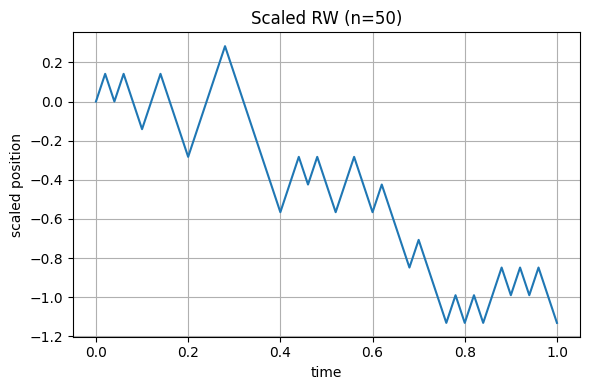

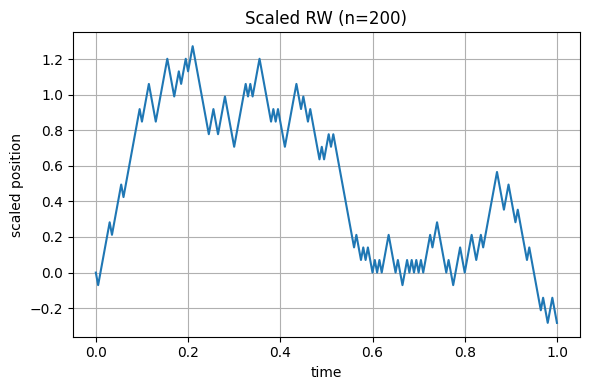

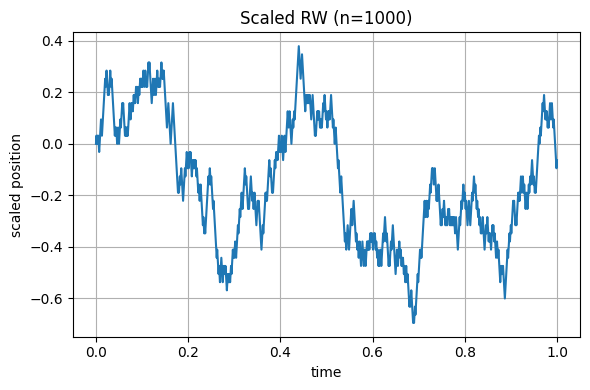

In [6]:
for n in [50, 200, 1000]:
    rw = simple_random_walk(n, rng)
    t = np.linspace(0, 1, n+1)
    plt.figure(); plt.plot(t, rw/np.sqrt(n))  # Scale by 1 / sqrt(n)
    plt.xlabel('time'); plt.ylabel('scaled position'); plt.title(f'Scaled RW (n={n})')
    plt.tight_layout(); plt.show()

*Ponder:* Compare this graph to the graph of a stock's price.

## 2) Brownian motion simulation and variance check

In [7]:
def brownian_motion(T, n, rng):
    dt = T/n
    dB = np.sqrt(dt)*rng.standard_normal(n)
    return np.concatenate(([0.0], np.cumsum(dB)))

This code defines Brownian motion. Instead of $\pm$1, a draw from a normal distribution is used, scaled by $\sqrt{t}$.

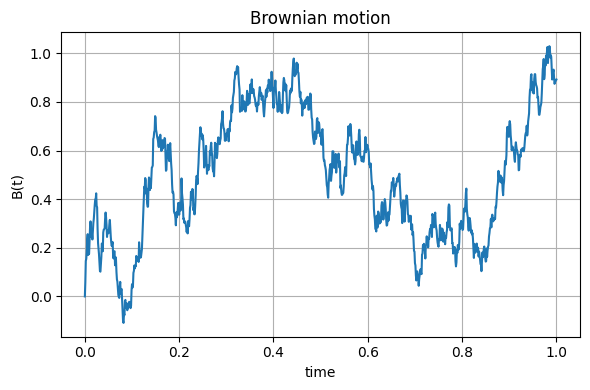

,t,Empirical Var ≈ t
0,0.25,0.2492
1,0.50,0.4907
2,0.75,0.7226
3,1.00,1.0115


In [8]:
n=1000
B = brownian_motion(T, n, rng)
t = np.linspace(0,T,n+1) #creates evenly space numbers
plt.figure(); plt.plot(t,B); plt.xlabel('time'); plt.ylabel('B(t)'); plt.title('Brownian motion'); plt.tight_layout(); plt.show()

ts = [0.25,0.5,0.75,1.0]
M = 4000
rows=[]
for tt in ts:
    n2=int(n*tt/T)
    vals = np.array([brownian_motion(tt, n2, rng)[-1] for _ in range(M)])
    rows.append((tt, np.var(vals)))
pd.DataFrame(rows, columns=['t','Empirical Var ≈ t']).round(4)

*Ponder:* How is the variance of the Brownian motion related to $t$?

## 3) GBM and its link to binomial

In [9]:
def gbm_paths(S0, mu, sigma, T, n_steps, N, rng):
    dt = T/n_steps
    S = np.full(N, S0)
    out = [S.copy()]
    for _ in range(n_steps):
        Z = rng.standard_normal(N)
        S *= np.exp((mu-0.5*sigma**2)*dt + sigma*np.sqrt(dt)*Z)
        out.append(S.copy())
    return np.array(out)

Here, we define geometric Brownian motion. Instead of adding values, we are multiplying them together. We have

$S_t = S_0 e^{(\mu-\frac{1}{2}\sigma^2)\times t + (\sigma\sqrt{t})\times Z}$

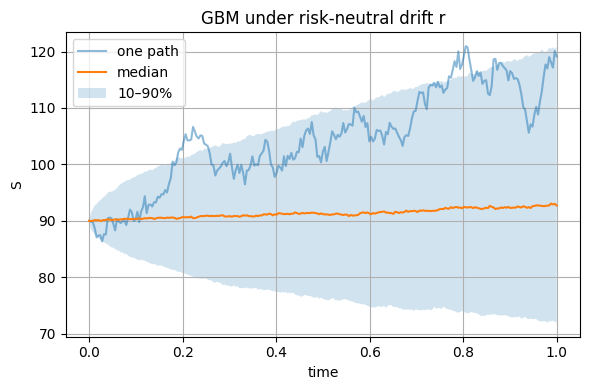

n=  2 u=1.1519 d=0.8681 p*=0.5539 (dt=0.5000)
n= 10 u=1.0653 d=0.9387 p*=0.5238 (dt=0.1000)
n= 50 u=1.0287 d=0.9721 p*=0.5106 (dt=0.0200)
n=200 u=1.0142 d=0.9860 p*=0.5053 (dt=0.0050)


In [10]:
N=2000; n_steps=252
paths = gbm_paths(S0, r, sigma, T, n_steps, N, rng)
t = np.linspace(0,T,n_steps+1)
q10,q50,q90 = np.quantile(paths, [0.1,0.5,0.9], axis=1)
plt.figure(); plt.plot(t, paths[:,0], alpha=0.5, label='one path')
plt.plot(t, q50, label='median'); plt.fill_between(t,q10,q90,alpha=0.2,label='10–90%')
plt.legend(); plt.xlabel('time'); plt.ylabel('S'); plt.title('GBM under risk-neutral drift r'); plt.tight_layout(); plt.show()

def crr_params(sigma, r, T, n):
    dt=T/n; u=math.exp(sigma*math.sqrt(dt)); d=1/u; p=(math.exp(r*dt)-d)/(u-d); return u,d,p,dt
for n in [2,10,50,200]:
    u,d,p,dt = crr_params(sigma, r, T, n)
    print(f'n={n:>3} u={u:.4f} d={d:.4f} p*={p:.4f} (dt={dt:.4f})')


## 4) Black–Scholes pricing and MC check

In [11]:
from math import log, sqrt, exp
from scipy.stats import norm

def bs_call_put(S0,K,r,sigma,T):
    d1=(log(S0/K)+(r+0.5*sigma**2)*T)/(sigma*sqrt(T))
    d2=d1-sigma*sqrt(T)
    call = S0*norm.cdf(d1)-K*exp(-r*T)*norm.cdf(d2)
    put  = K*exp(-r*T)*norm.cdf(-d2)-S0*norm.cdf(-d1)
    return call, put

This gives the Black-Scholes price of a European call and put option. Hopefully, our Monte Carlo simulations will approach this price.

In [12]:
def mc_euro_call(S0,K,r,sigma,T,N,rng):
    Z=rng.standard_normal(N)
    ST=S0*np.exp((r-0.5*sigma**2)*T + sigma*sqrt(T)*Z) #end stock price
    return float(np.mean(np.exp(-r*T)*np.maximum(ST-K,0.0))) #avg o discounted payoffs

c,p = bs_call_put(S0,K,r,sigma,T)
mc = mc_euro_call(S0,K,r,sigma,T,200_000,rng)
print('BS call=',round(c,4),'  BS put=',round(p,4),'  MC call≈',round(mc,4))

BS call= 5.0912   BS put= 10.2142   MC call≈ 5.0901


Note the formula for the output: the mean of $e^{-rT}\times \max{(S_T-K,0)}$

# Homework

Due 10/17 by 11:59PM

**Q1.** Why do we scale the random walk by $\frac{1}{\sqrt{n}}$?

**Explanation:**
<font color="#66FFoo">  
For a 1D random walk, the typical distance of the walk drifts farther away from the starting point as n increases. After n steps, the displacement from the starting point is about sqrt(n) away, we scale down by sqrt(n) to keep the displacement of the walk from exploading to infinity.
<font color="#66FFoo">  
Also, the variance of the walk is n, if we scale the walks by 1/(sqrt(n)), the variance always stays at 1.   


**Q2.** What does the concept of "drift" mean in a stochastic process? How do we use it in the Black-Scholes model?

**Explanation:**
<font color="#66FFoo">  
In a stochastic process, drift describes the average rate of change over time of the random variable and is the deterministic "trend" component of the process.

The Black-Scholes model assumes the stock price follows GBM which satisfies the SDE:
dSt​=μSt​dt+σSt​dWt
<font color="#66FFoo">  
The drift μ and represents the stock's actual expected rate of return. However, in practice μ is very difficult to estimate. In Black-Scholes we replace μ with the risk neutral rate r to make options price calculations simpler under the risk-neutral measure.



**Q3.** Create a function that uses Monte Carlo simulation to price a put option. Let $S_0=120.0, K=130.0, r=0.05, \sigma=0.1, T=1.0$. Compare 5 runs of your function to the Black-Scholes price.

**Explanation:**

In [13]:
#code for Q3

S0 = 120.0
K = 130.0
r = 0.05
sigma = 0.1
T = 1.0

def mc_euro_put(S0,K,r,sigma,T,N,rng):
    Z=rng.standard_normal(N)
    ST=S0*np.exp((r-0.5*sigma**2)*T + sigma*sqrt(T)*Z) #end stock price

    return float(np.mean(np.exp(-r*T)*np.maximum(K-ST,0.0))) # avg o discounted payoffs, only changed ST-K to K-ST for the put

c,p = bs_call_put(S0,K,r,sigma,T)
mc = mc_euro_put(S0,K,r,sigma,T,200_000,rng)

l = []
for i in range(5):
    mc = mc_euro_put(S0,K,r,sigma,T,200_000,rng)
    l.append(mc)

print('  BS put=',round(p,4),'  MC put≈',round(sum(l)/len(l),4))
print("5 Monte Carlo runs: ",l)


  BS put= 6.9056   MC put≈ 6.8999
5 Monte Carlo runs:  [6.907038747664425, 6.876913385260961, 6.8918531731582515, 6.9046898617409695, 6.918962629089163]


**Q4.** Suppose that each time step is related to the previous time step, instead of being independent. Adjust the Monte Carlo simulation code to account for lag 1 autocorrelations of $\rho =\{-.9, -.4, .4, .9\}$.

**Explanation:**

In [14]:
#code for Q4

# The code below uses an AR(1) process, AR(1) predicts a time series's current value based on the immediate preceding value and a random error term
# AR(1) formula: Z(t) = intercept + rho*Z(t-1) + epsilon    # epsilon is random error term
# The correlation between any 2 random variables in an AR(1) process equals rho^k, k is the number of time steps between Z's
# So, the correlation between the current and preceding variable will by rho^1. The two terms are correlated by rho.

S0 = 120.0
K = 130.0
r = 0.05
sigma = 0.1
Nsteps = 252
Npaths = 10000
T = 1.0
rhos = [-0.9, -0.4, 0.4, 0.9]

def mc_euro_put_corr(S0, K, r, sigma, T, Nsteps, Npaths, rho, rng):
    dt = T / Nsteps
    disc = np.exp(-r * T)

    # Initialize
    S = np.full(Npaths, S0)
    Z = np.zeros(Npaths)

    for t in range(Nsteps):
        eps = rng.standard_normal(Npaths) # New random shock, keeps model random
        Z = rho * Z + sqrt(1 - rho**2) * eps  # AR(1) correlated shocks, sqrt(1-rho**2) keeps the variance = 1
        S *= np.exp((r - 0.5 * sigma**2) * dt + sigma * sqrt(dt) * Z)

    # Discounted payoff
    payoff = np.maximum(K - S, 0.0)
    return disc * np.mean(payoff)

for rho in rhos:
    price = mc_euro_put_corr(S0, K, r, sigma, T, Nsteps, Npaths, rho, rng)
    print(f"ρ={rho:>4}: MC put ≈ {price:.4f}")

# I first tried to use a cholesky decomposition but couldn't figure out how to correlate all the consecuative normals without messing up the previous correlation

ρ=-0.9: MC put ≈ 4.3860
ρ=-0.4: MC put ≈ 5.5047
ρ= 0.4: MC put ≈ 8.9869
ρ= 0.9: MC put ≈ 17.6998


**Q5.** Write down your thoughts about the project you want to present at the end of the semester.

**Explanation:**

I would prefer to do a project related to either options pricing or queuing systems

Idea 1:
Project based off of:

 *Valuing American Options by Simulation: A simple least squares approach*, Longstaff and Schwartz (significant research paper from 2001)

 - Could implment their model in python, could measure computation time of only considering "in the money" paths vs all paths
 - Try to add jump diffusion to the model, try to address drawbacks of brownian motion
 - Could then experiment with different regression techniques, could try different basis functions
 - Use real stock data to see the effectiveness of LMC
 - Incorporate correlated assets somehow?

-There's several articles that reference this paper, could be good to look at
- https://berthine.github.io/doc/berthine_master-document.pdf
- https://www.soa.org/globalassets/assets/files/static-pages/research/arch/2005/arch05v39n1_15.pdf

Idea 2:

Praneet told me about his idea of doing something related to online server queuing systems and I think that would be really cool to look into.

Idea 3:

Lucian's idea of looking at the current housing market would be interesting...

Quetions:
- What do typicaly iRisk presentations look like? How long? Format? Deliverable?
-




**Q6.** Share your results from last week's homework #2 (on exotic options). Describe your process and their process. What similarities and differences are there?


---



**Explantion:**

Momin chose to model an Asian call option. The payoff of an Asian option depends on the **average** price of the underlying stock over the time period. Asian options are generally cheaper than standard options because they are less votatile.

Momin's code implemented the Asian option by simulating the underlying price at each time step and keeping a running sum of the price for each path. At the end of the simulation, he divided the running price sums by the number of steps to find each path's average price. He compared the average price to K and included a payoff of (avg - K) if the average was in the money. Lastly he calculated the price by discounting the payoffs to the present.

I chose to model a binary option which is an "all or nothing" contract based on the underlying's price at experation.

**Differences**

- I was able to simulate all the terminal stock prices at once because that was all the price of the binary option depended upon, Momin had to iterate through each step of his price simualtion to sum prices needed for the final average calculation.
- The final logic for calcuating payoffs is different because we chose different options, the binary option depends on the terminal price and the asian option depends on the average price.

**Similarities**

- We both simulated the stock prices using GBM
- We both had to discount our expected payoff back to t=0 to find the price.

